#  Парсинг данных из телеграмм канала @DtOperativno 
В канале - оперативная информация обо всем, что происходит в московском транспорте. Официальный канал Дептранса.

In [55]:
import pandas as pd
import re
import os
import nltk
from nltk.corpus import stopwords
import pymorphy3
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import random
import numpy as np

from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [12]:
df = pd.read_csv('chats.csv')
df

,message
0,В период с 12 ноября 2025 г. до 15 февраля 202...
1,Движение на Большой кольцевой линии (11) в гра...
2,Движение на Большой кольцевой линии (11) по ча...
3,На Большой кольцевой линии (11) временно увели...
4,Движение на Международном шоссе (съезд на Лени...
...,...
9995,❗️С 3:30 24 июня до 3:30 26 июня на Савеловско...
9996,Проезжая часть освобождена.
9997,❗️На внешней стороне 77 км МКАД столкнулись ав...
9998,"Доброе утро! Cегодня, по данным ЦОДД, вечером ..."


**Файл иммется, начинаем обработку**

## Этап 1. Предобработка текстов Telegram-сообщений

На этом этапе:
- Удалим пропуски и дубликаты
- Очистим тексты от ссылок, эмодзи, хэштегов, пунктуации
- Приведём текст к нижнему регистру
- Проверим результат очистки

In [13]:
# Удаляем строки с пустыми сообщениями
df = df.dropna(subset=["message"]).reset_index(drop=True)
print(f"Размер после удаления пустых строк: {df.shape[0]} постов")

Размер после удаления пустых строк: 9608 постов


### Очистка текста от лишних символов

Теперь напишем функцию, которая уберет:
- ссылки (http, https, t.me и т.д.);
- хэштеги, упоминания, эмодзи;
- все символы кроме букв;
- лишние пробелы и приведет к нижнему регистру.

In [14]:
def clean_text(text):
    # Удаляем ссылки
    text = re.sub(r"http\S+|www\S+|t\.me/\S+", "", text)
    
    # Удаляем хэштеги и упоминания
    text = re.sub(r"#\S+|@\S+", "", text)
    
    # Удаляем все, кроме букв и пробелов
    text = re.sub(r"[^а-яА-ЯёЁ\s]", " ", text)
    
    # Приводим к нижнему регистру
    text = text.lower()
    
    # Удаляем лишние пробелы
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Применяем очистку
df["clean_text"] = df["message"].apply(clean_text)

# Проверим первые примеры
df.head(5)

,message,clean_text
0,В период с 12 ноября 2025 г. до 15 февраля 202...,в период с ноября г до февраля г на участках п...
1,Движение на Большой кольцевой линии (11) в гра...,движение на большой кольцевой линии в графике
2,Движение на Большой кольцевой линии (11) по ча...,движение на большой кольцевой линии по часовой...
3,На Большой кольцевой линии (11) временно увели...,на большой кольцевой линии временно увеличены ...
4,Движение на Международном шоссе (съезд на Лени...,движение на международном шоссе съезд на ленин...


### Проверка результата очистки

Посмотрим, сколько сообщений после очистки стали пустыми (значит, там не было текста),
и визуально проверим несколько примеров.

In [16]:
# Считаем, сколько сообщений после очистки стали пустыми
empty_count = (df["clean_text"].str.len() == 0).sum()
print(f"Количество пустых строк после очистки: {empty_count}")

# Удалим полностью пустые строки
df = df[df["clean_text"].str.len() > 0].reset_index(drop=True)
print("Итоговое количество сообщений:", len(df))

# Проверим несколько случайных примеров
df.sample(5, random_state=42)[["message", "clean_text"]]

Количество пустых строк после очистки: 0
Итоговое количество сообщений: 9608


,message,clean_text
2114,Доброе утро!\n\nСегодня в городе ожидается дож...,доброе утро сегодня в городе ожидается дождь н...
5107,"С 3 августа для автобусов е59, 181, 278, 353, ...",с августа для автобусов е и высадка переноситс...
8151,На южном участке Калужско-Рижской линии (6) вр...,на южном участке калужско рижской линии времен...
2880,❗️На внешней стороне 37-го км МКАД произошло Д...,на внешней стороне го км мкад произошло дтп с ...
7991,❗️На Ленинском проспекте в районе д.99 произош...,на ленинском проспекте в районе д произошел ин...


- Мы удалили 392 пустых строки из исходного файла.
- Очистка прошла успешно: ссылки, хэштеги и эмодзи удалены.
- В колонке `clean_text` теперь чистый текст

Далее перейдем к Этапу 2 — токенизация и лемматизация.

# Этап 2. Токенизация и лемматизация текста

Теперь, когда текст очищен, нужно привести слова к их нормальной форме (лемме).  
Мы также удалим стоп-слова.
Используем библиотеку `pymorphy3` для лемматизации и `nltk` для списка стоп-слов на русском языке.

In [19]:
# Загружаем стоп-слова NLTK
nltk.download("stopwords")

# Список русских стоп-слов
stop_words = set(stopwords.words("russian"))

# Добавим свои специфические слова, чтобы убрать "мусор" из корпуса
custom_stopwords = {
    "москва", "транспорт", "дорога", "автомобиль",
    "оперативно", "движение", "улица", "проезд", "сообщение"
}
stop_words = stop_words.union(custom_stopwords)

print(f"Количество стоп-слов: {len(stop_words)}")
list(stop_words)[:10]

Количество стоп-слов: 160


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


['во',
 'него',
 'чем',
 'них',
 'что',
 'себе',
 'чуть',
 'после',
 'тогда',
 'транспорт']

### Лемматизация текста

Теперь создадим функцию, которая:
- разобьет текст на слова;
- приведет каждое слово к нормальной форме (лемме);
- удалит стоп-слова и короткие токены (1–2 символа);
- вернет список очищенных лемм.

In [20]:
# Инициализация лемматизатора
morph = pymorphy3.MorphAnalyzer()

def lemmatize_text(text):
    tokens = re.findall(r"[а-яА-ЯёЁ]+", text)
    lemmas = []
    for token in tokens:
        lemma = morph.normal_forms(token)[0]
        if lemma not in stop_words and len(lemma) > 2:
            lemmas.append(lemma)
    return lemmas

# Применяем лемматизацию
df["lemmas"] = df["clean_text"].apply(lemmatize_text)

# Проверим несколько примеров
df[["clean_text", "lemmas"]].head(5)

,clean_text,lemmas
0,в период с ноября г до февраля г на участках п...,"[период, ноябрь, февраль, участок, проектирова..."
1,движение на большой кольцевой линии в графике,"[большой, кольцевой, линия, графика]"
2,движение на большой кольцевой линии по часовой...,"[большой, кольцевой, линия, часовой, стрелка, ..."
3,на большой кольцевой линии временно увеличены ...,"[большой, кольцевой, линия, временно, увеличит..."
4,движение на международном шоссе съезд на ленин...,"[международный, шоссе, съезд, ленинградский, ш..."


Следующий этап — **Этап 3: описательная аналитика**.  
Мы посмотрим, как распределяются длины сообщений, какие слова встречаются чаще всего и визуализируем результаты.

# Этап 3. Описательная аналитика

На этом этапе посмотрим, как распределяются сообщения по длине, какие слова встречаются чаще всего,  
и построим облако слов для общего представления о тематике корпуса.

count    9608.000000
mean       25.222731
std        24.852657
min         1.000000
25%        10.000000
50%        19.000000
75%        29.000000
max       346.000000
Name: len_words, dtype: float64


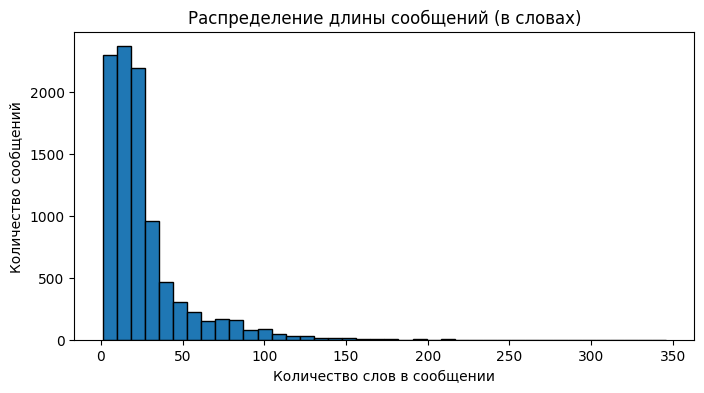

In [24]:
# Считаем длину сообщений в словах
df["len_words"] = df["lemmas"].apply(len)

# Базовая статистика по длине
print(df["len_words"].describe())

# Гистограмма распределения длины сообщений
plt.figure(figsize=(8, 4))
plt.hist(df["len_words"], bins=40,  edgecolor="black")
plt.title("Распределение длины сообщений (в словах)")
plt.xlabel("Количество слов в сообщении")
plt.ylabel("Количество сообщений")
plt.show()

Первые три десятка длины слов у нас примерно по 25% - остальные в 2 и более раз меньше

### Частотность слов

Теперь посчитаем, какие слова встречаются чаще всего в нашем корпусе.  
Это поможет понять, какие понятия преобладают в текстах (например, ремонт, перекрытие, станция и т.д.).

район           3867
участок         3436
маршрут         3388
сторона         3079
метро           3025
город           2546
это             2520
работа          2462
проведение      2305
подробный       2231
поезд           2139
связать         2124
полоса          1902
инфографик      1888
мкад            1884
автобус         1874
работать        1870
шоссе           1861
произойти       1769
путь            1764


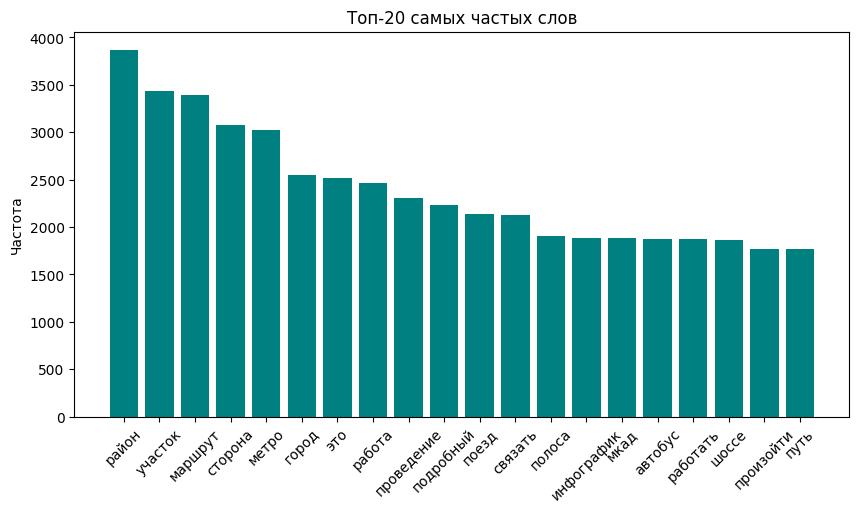

In [26]:
# Соберем все леммы в один список
all_lemmas = [lemma for lemmas in df["lemmas"] for lemma in lemmas]

# Посчитаем частоты
word_counts = Counter(all_lemmas) # для построения частотного словаря корпуса
top_words = word_counts.most_common(20)

# Выведем топ-20
for word, freq in top_words:
    print(f"{word:15} {freq}")

# Визуализируем частоты
plt.figure(figsize=(10, 5))
plt.bar([w for w, _ in top_words], [f for _, f in top_words], color="teal")
plt.title("Топ-20 самых частых слов")
plt.xticks(rotation=45)
plt.ylabel("Частота")
plt.show()

### Облако слов

Построим облако слов, чтобы наглядно увидеть, какие слова встречаются чаще.  
Чем больше слово на картинке — тем чаще оно появляется в корпусе.

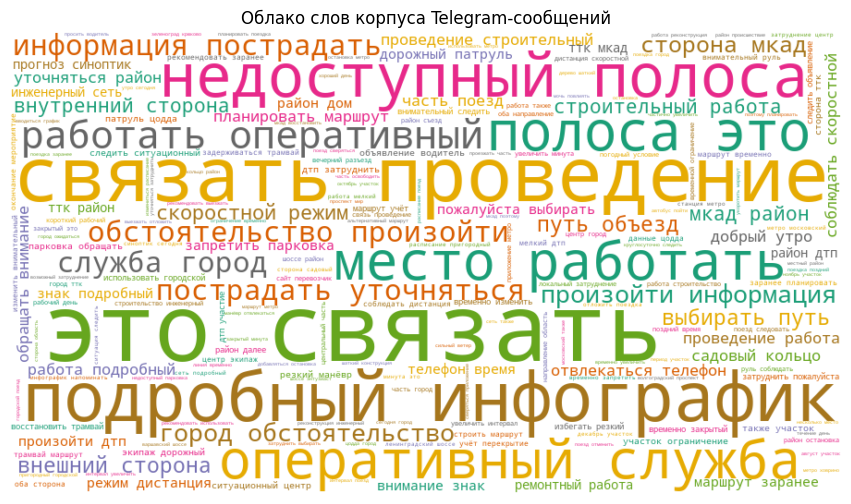

In [33]:
# Создаем строку из всех лемм
text_for_cloud = " ".join(all_lemmas)

# Генерируем облако слов
wordcloud = WordCloud(width=900, height=500, background_color="white", colormap="Dark2").generate(text_for_cloud)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов корпуса Telegram-сообщений")
plt.show()

По результатам анализа можно сделать следующие наблюдения:

1. **Частотный анализ** показывает, что наиболее часто встречающиеся слова —  
   *«район», «участок», «маршрут», «сторона», «метро», «город» и тд.  
   Мы видим, что тексты связаны с дорожной и транспортной ситуацией

2. **Облако слов** демонстрирует высокую насыщенность корпуса служебной терминологией.  
   Часто встречаются слова, связанные с инфраструктурой и эксплуатацией: *«проведение», «работа», «полоса», «внешний», «строительный», «служба»*.  
   Также присутствуют выражения вроде *«оперативный», «инфографик», «обстоятельство», «пострадать»*, что отражает информационный и предупреждающий характер сообщений.

3. **Распределение длины сообщений** (см. предыдущую ячейку) показывает, что большинство постов короткие — до 30 слов.  
   Это объясняется форматом новостных уведомлений: тексты лаконичны, без описательных вставок.

В целом корпус отражает системные сообщения о дорожных изменениях, ремонтах, ограничениях движения и инфраструктурных работах.  

# Этап 4. Тематическое моделирование: LDA и BERTopic

- **LDA** хорошо работает на мешке слов, если темы устойчивы и тексты не слишком короткие.  
  Даёт интерпретируемые списки слов, удобно сравнивать `K` по метрике **coherence c_v**.
- **BERTopic** использует эмбеддинги предложений и кластеризацию (UMAP + HDBSCAN + c-TF-IDF).  
  Он лучше справляется с короткими, однотипными постами (наш случай), нередко даёт более осмысленные кластеры.

### Что означают метрики

- **Coherence (c_v)** — мера согласованности слов внутри темы.  
  Чем выше coherence, тем чаще слова из одной темы встречаются рядом в текстах.  
  Мы вычисляем её с помощью функции `CoherenceModel` из библиотеки *gensim*, которая оценивает  
  степень совместного появления топ-слов каждой темы в исходных документах.

- **Topic Diversity** — показатель разнообразия тем.  
  Это доля уникальных слов среди всех топ-слов разных тем.  
  Например, если в 7 темах по 10 слов встречается 60 уникальных слов из 70 возможных,  
  то diversity = 60 / 70 = 0.86. Чем выше значение, тем меньше пересечений между темами.

Обе метрики вместе позволяют оценить качество модели:
- высокая **coherence** означает, что темы семантически устойчивы;
- высокая **diversity** — что темы различаются между собой и не дублируют друг друга.

### План работы
1. Подготовим корпус: биграммы, словарь, BoW/TF-IDF.
2. Обучим LDA на разных `K`, выберем `K*` по **coherence c_v** и проверим топ-слова/примеры.
3. Обучим BERTopic, получим темы, посчитаем **coherence c_v** и **Topic Diversity**.
4. Сравним модели и выберем финальную по метрикам и интерпретируемости.

In [40]:
random.seed(42)
np.random.seed(42)

# Создаем биграммы (например, "ремонт дороги", "третье кольцо")
phrases = Phrases(df["lemmas"], min_count=20, threshold=10)
bigram = Phraser(phrases)

# Добавляем столбец с биграммами
df["lemmas_bg"] = df["lemmas"].apply(lambda x: bigram[x])

# Создаем словарь
dictionary = Dictionary(df["lemmas_bg"])
dictionary.filter_extremes( # отбрасывает слишком редкие или слишком частые слова
    no_below=10, # удалить все слова, которые встречаются меньше чем в 10 документах.
   no_above=0.5) # удалить все слова, которые встречаются более чем в 50% документов

# Создаем корпус (мешок слов)
corpus_bow = [dictionary.doc2bow(tokens) for tokens in df["lemmas_bg"]]

print("Размер словаря:", len(dictionary))
print("Пример BoW-документа:", corpus_bow[0][:10])

Размер словаря: 1877
Пример BoW-документа: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


### Подбор оптимального количества тем для LDA

Чтобы определить подходящее число тем `K`, обучим несколько моделей LDA с разным количеством тем  
и вычислим метрику **coherence c_v**.  
Значение `K`, при котором coherence максимален, выберем как оптимальное.

K=1 → coherence c_v=0.3011
K=2 → coherence c_v=0.3438
K=3 → coherence c_v=0.5618
K=4 → coherence c_v=0.5843
K=5 → coherence c_v=0.6683
K=6 → coherence c_v=0.6524
K=7 → coherence c_v=0.6871
K=8 → coherence c_v=0.6468
K=9 → coherence c_v=0.6747
K=10 → coherence c_v=0.6129
K=11 → coherence c_v=0.6333
K=12 → coherence c_v=0.6429
K=13 → coherence c_v=0.5970
K=14 → coherence c_v=0.6755
K=15 → coherence c_v=0.6264
K=16 → coherence c_v=0.6135
K=17 → coherence c_v=0.6461
K=18 → coherence c_v=0.6167
K=19 → coherence c_v=0.6004
K=20 → coherence c_v=0.6120
K=21 → coherence c_v=0.5976
K=22 → coherence c_v=0.6124
K=23 → coherence c_v=0.6200
K=24 → coherence c_v=0.6017
K=25 → coherence c_v=0.6162


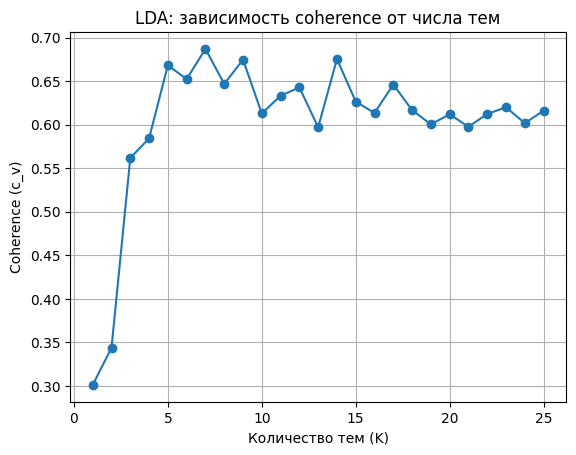

Оптимальное K: 7


In [46]:
def train_lda_and_coherence(corpus, dictionary, texts, k, passes=10):
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary, # ID соответствует слово
        num_topics=k, 
        passes=passes, # сколько раз модель проходит по всему корпусу при обучении
        random_state=42,
        chunksize=2000 # размер порции документов, обрабатываемых за один шаг обучения
    )
    cm = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    return lda, cm.get_coherence()

K_values = [i for i in range (1, 26)]
coherences = []
lda_models = {}

for k in K_values:
    lda_k, coh_k = train_lda_and_coherence(corpus_bow, dictionary, df["lemmas_bg"].tolist(), k)
    lda_models[k] = lda_k
    coherences.append(coh_k)
    print(f"K={k} → coherence c_v={coh_k:.4f}")

plt.plot(K_values, coherences, marker="o")
plt.title("LDA: зависимость coherence от числа тем")
plt.xlabel("Количество тем (K)")
plt.ylabel("Coherence (c_v)")
plt.grid(True)
plt.show()

best_k = K_values[int(np.argmax(coherences))]
lda_best = lda_models[best_k]
print(f"Оптимальное K: {best_k}")

In [58]:
# Получаем топ-10 слов для каждой темы
lda_topic_words = []
for t in range(lda_best.num_topics):
    terms = lda_best.show_topic(t, topn=10)
    lda_topic_words.append([w for w, _ in terms])

# Функция расчёта Topic Diversity
def topic_diversity(topic_words, topn=10):
    all_words = [w for topic in topic_words for w in topic[:topn]]
    unique_words = len(set(all_words))
    total_words = len(topic_words) * topn
    return unique_words / total_words

# Вычисляем разнообразие тем
td_lda = topic_diversity(lda_topic_words, topn=10)
print(f"LDA Topic Diversity = {td_lda:.3f}")

LDA Topic Diversity = 0.857


### Просмотр тем LDA

Теперь посмотрим топ-слова по каждой теме и несколько сообщений, относящихся к этим темам.  
Это поможет оценить интерпретируемость модели.

In [50]:
# Выведем топ-слова по каждой теме
for i in range(lda_best.num_topics):
    terms = lda_best.show_topic(i, topn=10)
    words = ", ".join([w for w, _ in terms])
    print(f"[Тема {i}] {words}")

# Посмотрим примеры сообщений для первых тем
def top_docs_for_topic(lda_model, corpus, topic_id, topn=3):
    scores = []
    for i, bow in enumerate(corpus):
        prob = dict(lda_model.get_document_topics(bow)).get(topic_id, 0)
        scores.append((prob, i))
    scores.sort(reverse=True)
    return [idx for _, idx in scores[:topn]]

for t in range(min(3, lda_best.num_topics)):
    print(f"\n[Тема {t}] Примеры сообщений:")
    for idx in top_docs_for_topic(lda_best, corpus_bow, t):
        print("-", df.loc[idx, "clean_text"])

[Тема 0] поезд, станция, часть_поезд, направление, путь, поездка, минута, также, участок, метро
[Тема 1] район, место_работать, оперативный_служба, город_обстоятельство, пострадать_уточняться, произойти_информация, объезд, выбирать_путь, произойти, временно_изменить
[Тема 2] участок, это_связать, подробный_инфографик, недоступный_полоса, проведение, закрытый, работа, также, переулок, проведение_строительный
[Тема 3] восстановить, район, мкад, ттк, цодда, садовый_кольцо, внешний_сторона, центр, город, внутренний_сторона
[Тема 4] место, водитель, парковка, район, временно, дом, связь, подробный, сторона, цодда
[Тема 5] город, сегодня, добрый_утро, прогноз_синоптик, избегать_резкий, цодда, соблюдать_скоростной, поездка, внимательный_руль, режим_дистанция
[Тема 6] метро, автобус, маршрут, остановка, трамвай, работать, вместо, пользоваться, сторона, линия

[Тема 0] Примеры сообщений:
- в ночь с ое на ое октября изменится движение на на некоторых станциях изменятся пути отправления поездов и

### BERTopic: современный подход

LDA основана на мешке слов и игнорирует порядок и контекст.  
BERTopic решает эту проблему, используя эмбеддинги предложений (Sentence Transformers), кластеризацию (HDBSCAN) и TF-IDF для интерпретации тем.

Этот подход особенно хорошо работает на коротких постах, где контекст важнее длины текста.

In [53]:
# Объединяем леммы обратно в строку
docs = df["lemmas_bg"].apply(lambda x: " ".join(x)).tolist()

# Загружаем мультиязычную модель для эмбеддингов
embedder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Инициализация модели BERTopic
topic_model = BERTopic(
    embedding_model=embedder, #  текст в числовой вектор
    min_topic_size=30,         # минимальное количество документов в теме
    calculate_probabilities=True, # сохраняет вероятности принадлежности документа к каждой теме.
    verbose=True # логирование
)

topics, probs = topic_model.fit_transform(docs)
topic_info = topic_model.get_topic_info()
topic_info.head(10)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-11-09 20:50:56,247 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/301 [00:00<?, ?it/s]

2025-11-09 20:51:17,600 - BERTopic - Embedding - Completed ✓
2025-11-09 20:51:17,601 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-11-09 20:51:27,891 - BERTopic - Dimensionality - Completed ✓
2025-11-09 20:51:27,893 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-09 20:51:28,904 - BERTopic - Cluster - Completed ✓
2025-11-09 20:51:28,911 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-09 20:51:29,003 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1606,-1_город_маршрут_район_цодда,"[город, маршрут, район, цодда, ттк, вода, поез...",[цодда соблюдать_скоростной режим_дистанция ин...
1,0,1311,0_оперативный_служба_место_работать_город_обст...,"[оперативный_служба, место_работать, город_обс...",[внешний_сторона мкад район съезд произойти дт...
2,1,1005,1_автобус_метро_остановка_маршрут,"[автобус, метро, остановка, маршрут, вместо, т...",[июнь выходной трамвай ходить бауманский день ...
3,2,573,2_недоступный_полоса_подробный_инфографик_это_...,"[недоступный_полоса, подробный_инфографик, это...",[сентябрь декабрь участок мкад недоступный_пол...
4,3,422,3_парковка_обращать_внимание_знак_участок_недо...,"[парковка_обращать, внимание_знак, участок, не...",[апрель участок год недоступный_полоса это_свя...
5,4,308,4_восстановить_далее_район_широта,"[восстановить, далее, район, широта, свх, мсд,...","[район мкад восстановить, район мкад восстанов..."
6,5,287,5_поезд_часть_поезд_станция_направление,"[поезд, часть_поезд, станция, направление, пут...",[октябрь октябрь октябрь измениться поезд пери...
7,6,258,6_минута_период_проведение_киносъ_мокнуть_подр...,"[минута, период, проведение_киносъ, мокнуть_по...",[октябрь период участок северный закрытый мину...
8,7,249,7_рекомендовать_заранее_учёт_перекрытие_планир...,"[рекомендовать_заранее, учёт_перекрытие, плани...",[период май декабрь участок парковый закрытый ...
9,8,211,8_добрый_утро_сегодня_мкад_поэтому_внимательны...,"[добрый_утро, сегодня, мкад_поэтому, вниматель...",[добрый_утро прогноз_синоптик сегодня город об...


### Оценка качества BERTopic

Мы рассчитаем две метрики:
- **Coherence (c_v)** — насколько логично объединены слова в темах.
- **Topic Diversity** — насколько темы различаются между собой по составу слов.

In [56]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def get_topic_words(model, topn=10):
    topics = []
    for topic_id in model.get_topic_freq().Topic:
        if topic_id == -1:
            continue
        words = [w for w, _ in model.get_topic(topic_id)[:topn]]
        topics.append(words)
    return topics

# Получаем слова тем
topic_words_bertopic = get_topic_words(topic_model)

# Coherence для BERTopic
cm_bertopic = CoherenceModel(
    topics=topic_words_bertopic,
    texts=df["lemmas_bg"].tolist(),
    dictionary=dictionary,
    coherence='c_v'
)
coh_bertopic = cm_bertopic.get_coherence()

# Topic Diversity
def topic_diversity(topics, topn=10):
    all_words = [w for t in topics for w in t[:topn]]
    return len(set(all_words)) / (len(topics) * topn)

td_bertopic = topic_diversity(topic_words_bertopic)

print(f"BERTopic → coherence c_v = {coh_bertopic:.4f}, Topic Diversity = {td_bertopic:.3f}")

BERTopic → coherence c_v = 0.6820, Topic Diversity = 0.626


## Итог сравнения LDA и BERTopic

В рамках анализа были обучены две модели:
- **LDA** — классическая вероятностная модель тематического анализа;
- **BERTopic** — современная модель на основе эмбеддингов предложений (Sentence Transformers).

| Модель | Кол-во тем | Coherence (c_v) | Topic Diversity |
|:--------|:------------|:----------------|:----------------|
| **LDA** | 7 | **0.6871** | **0.857** |
| **BERTopic** | 10 | 0.6820 | 0.626 |

---

### 1. Темы, выделенные LDA (K = 7)

| № темы | Основные слова | Смысловое направление |
|:--|:--|:--|
| **0** | поезд, станция, путь, поездка, метро | движение поездов, расписания, изменения маршрутов |
| **1** | район, работать, служба, обстоятельство, объезд, изменить | происшествия и служебные сообщения |
| **2** | участок, инфографик, полоса, работа, строительный | ремонты и перекрытия дорог |
| **3** | мкад, ттк, кольцо, центр, сторона, город | транспортная инфраструктура и магистрали |
| **4** | водитель, парковка, дом, связь, сторона | парковка и локальные изменения движения |
| **5** | город, сегодня, прогноз, синоптик, руль, дистанция | погодные условия и предупреждения |
| **6** | метро, автобус, маршрут, остановка, трамвай, линия | общественный транспорт |

**Coherence = 0.6871** и **Topic Diversity = 0.857** свидетельствуют о том, что темы устойчивы, различимы и почти не пересекаются.  
Это высокий показатель: модель выделила чёткие смысловые кластеры без избыточного дублирования слов.

---

### 2. Темы BERTopic
BERTopic также корректно отразил структуру корпуса, но темы частично перекрывались.  
По coherence (0.6820) результат близкий, однако Topic Diversity (0.626) оказался заметно ниже, что говорит о меньшей различимости кластеров.  
Темы совпадают по смыслу с LDA, но часто объединяют несколько подтем в одну.

---

### 3. Сравнительный анализ
- LDA даёт лучшие метрики и более структурированные темы.   
- Оба подхода фиксируют одни и те же смысловые оси — транспорт, городские службы — но LDA описывает их строже и более чисто.

---

### 4. Вывод
Модель **LDA** показала наилучшее качество тематического разбиения 
Она лучше всего подходит для анализа данного корпуса сообщений канала @DtOperativno и будет использована в дальнейших визуализациях и интерпретации результатов.

# Этап 5. Визуализация и сводка тем LDA

На этом этапе мы:
- посчитаем распределение сообщений по темам
- визуализируем долю каждой темы
- соберём таблицу с топ-словами и примерами сообщений

In [59]:
# Получаем распределение вероятностей тем для каждого документа
topics_per_doc = [sorted(lda_best[bow], key=lambda x: -x[1])[0][0] for bow in corpus_bow]
df["topic_id"] = topics_per_doc

# Считаем распределение по темам
topic_counts = df["topic_id"].value_counts().sort_index()
topic_share = topic_counts / len(df)

# Формируем DataFrame с основными данными по темам
topic_summary = pd.DataFrame({
    "Тема": topic_counts.index,
    "Количество сообщений": topic_counts.values,
    "Доля (%)": (topic_share.values * 100).round(2)
})

topic_summary

,Тема,Количество сообщений,Доля (%)
0,0,380,3.96
1,1,1661,17.29
2,2,2200,22.90
3,3,1753,18.25
4,4,666,6.93
5,5,799,8.32
6,6,2149,22.37


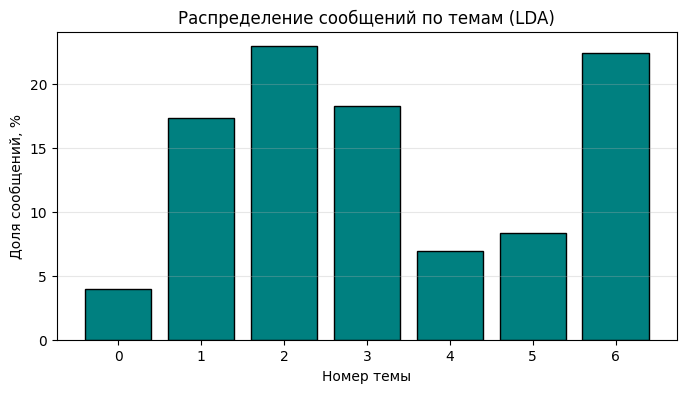

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(topic_summary["Тема"], topic_summary["Доля (%)"], color="teal", edgecolor="black")
plt.title("Распределение сообщений по темам (LDA)")
plt.xlabel("Номер темы")
plt.ylabel("Доля сообщений, %")
plt.xticks(topic_summary["Тема"])
plt.grid(axis="y", alpha=0.3)
plt.show()

Смотря на график распределния сообщений по темам, можем сказать, что в телеграмм канале с оперативной информацией Диптранса Москвы преобладают сообщения про Общественный траснпорт, транспортные происшествия и инфраструктуру 